Import numpy and sklearn method.

In [2]:
import numpy as np
from sklearn.datasets import load_files

print(np.__version__)

1.20.1


In [3]:
import sklearn
print(sklearn.__version__)

0.24.1


Copy dataset from git repo. TESTTest

In [4]:
!git clone https://github.com/Horea94/Fruit-Images-Dataset

fatal: destination path 'Fruit-Images-Dataset' already exists and is not an empty directory.


Set the path directory to the cloned test and train data.
load_dataset() returns the filenames, integer classes and string classes that are stored in file directory.


1.   names_train is a vector that contains the filepath of all images from the training set
2.   names_test is a vector that contains the filepath of all images from the test set
3.   intclass_train is a vector containing the int class values (1-131) of all images from the training set
4.   intclass_test is a vector containing the int class values (1-131) of all images from the test set
5.   stringclass_train is a vector containing the string label of class of all images from the training set
6.   stringclass_test is a vector containing the string label of class of all images from the test set






In [5]:
#train_dir_adriano = ''
#test_dir = ''
train_dir = 'C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/Pycharm/Fruit-Images-Dataset/Training/'
test_dir = 'C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/Pycharm/Fruit-Images-Dataset/Test/'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files, targets, target_labels
    
names_train, intclass_train, stringclass_train = load_dataset(train_dir)
names_test, intclass_test, stringclass_test = load_dataset(test_dir)

print('Loading complete!')
print('Training set size : ',  names_train.shape[0])
print('Testing set size : ', names_test.shape[0])
print(stringclass_train)

Loading complete!
Training set size :  67692
Testing set size :  22688
['Apple Braeburn' 'Apple Crimson Snow' 'Apple Golden 1' 'Apple Golden 2'
 'Apple Golden 3' 'Apple Granny Smith' 'Apple Pink Lady' 'Apple Red 1'
 'Apple Red 2' 'Apple Red 3' 'Apple Red Delicious' 'Apple Red Yellow 1'
 'Apple Red Yellow 2' 'Apricot' 'Avocado' 'Avocado ripe' 'Banana'
 'Banana Lady Finger' 'Banana Red' 'Beetroot' 'Blueberry' 'Cactus fruit'
 'Cantaloupe 1' 'Cantaloupe 2' 'Carambula' 'Cauliflower' 'Cherry 1'
 'Cherry 2' 'Cherry Rainier' 'Cherry Wax Black' 'Cherry Wax Red'
 'Cherry Wax Yellow' 'Chestnut' 'Clementine' 'Cocos' 'Corn' 'Corn Husk'
 'Cucumber Ripe' 'Cucumber Ripe 2' 'Dates' 'Eggplant' 'Fig' 'Ginger Root'
 'Granadilla' 'Grape Blue' 'Grape Pink' 'Grape White' 'Grape White 2'
 'Grape White 3' 'Grape White 4' 'Grapefruit Pink' 'Grapefruit White'
 'Guava' 'Hazelnut' 'Huckleberry' 'Kaki' 'Kiwi' 'Kohlrabi' 'Kumquats'
 'Lemon' 'Lemon Meyer' 'Limes' 'Lychee' 'Mandarine' 'Mango' 'Mango Red'
 'Mangostan' 

Show distribution of images to the different classes.

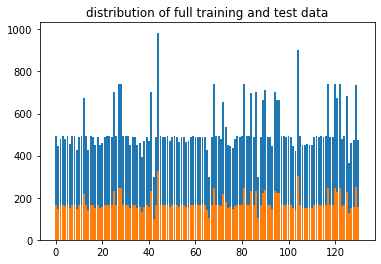

In [6]:
import matplotlib.pyplot as plt

(intclass, counts) = np.unique(intclass_train, return_counts=True)
plt.bar(intclass, counts)
plt.title('distribution of full training and test data')
full_train_frequencies = np.asarray((intclass, counts)).T

(intclass, counts) = np.unique(intclass_test, return_counts=True)
plt.bar(intclass, counts)
full_test_frequencies = np.asarray((intclass, counts)).T

Datasets can be reduced for compiling: original size of the training dataset is 67692 images; original size of the test dataset is 22688 images.

In [32]:
#train_datasize = 40000
#test_datasize = 10000
#names_train = names_train[:train_datasize]
#names_test = names_test[:test_datasize]
#intclass_train = intclass_train[:train_datasize]
#intclass_test = intclass_test[:test_datasize]
#print('Training set size : ',  names_train.shape[0])
#print('Testing set size : ', names_test.shape[0])
#print(stringclass_train)
#print(intclass_train.shape)
#print(intclass_test.shape)

Training set size :  4000
Testing set size :  1000
['Apple Braeburn' 'Apple Crimson Snow' 'Apple Golden 1' 'Apple Golden 2'
 'Apple Golden 3' 'Apple Granny Smith' 'Apple Pink Lady' 'Apple Red 1'
 'Apple Red 2' 'Apple Red 3' 'Apple Red Delicious' 'Apple Red Yellow 1'
 'Apple Red Yellow 2' 'Apricot' 'Avocado' 'Avocado ripe' 'Banana'
 'Banana Lady Finger' 'Banana Red' 'Beetroot' 'Blueberry' 'Cactus fruit'
 'Cantaloupe 1' 'Cantaloupe 2' 'Carambula' 'Cauliflower' 'Cherry 1'
 'Cherry 2' 'Cherry Rainier' 'Cherry Wax Black' 'Cherry Wax Red'
 'Cherry Wax Yellow' 'Chestnut' 'Clementine' 'Cocos' 'Corn' 'Corn Husk'
 'Cucumber Ripe' 'Cucumber Ripe 2' 'Dates' 'Eggplant' 'Fig' 'Ginger Root'
 'Granadilla' 'Grape Blue' 'Grape Pink' 'Grape White' 'Grape White 2'
 'Grape White 3' 'Grape White 4' 'Grapefruit Pink' 'Grapefruit White'
 'Guava' 'Hazelnut' 'Huckleberry' 'Kaki' 'Kiwi' 'Kohlrabi' 'Kumquats'
 'Lemon' 'Lemon Meyer' 'Limes' 'Lychee' 'Mandarine' 'Mango' 'Mango Red'
 'Mangostan' 'Maracuja' 'Melon Pi

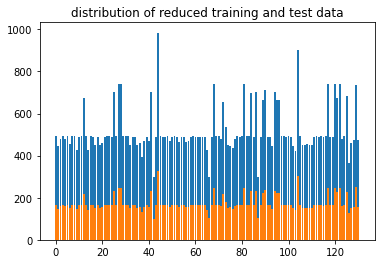

In [7]:
(intclass, counts) = np.unique(intclass_train, return_counts=True)
plt.bar(intclass, counts)
plt.title('distribution of reduced training and test data')
reduced_train_frequencies = np.asarray((intclass, counts)).T

(intclass, counts) = np.unique(intclass_test, return_counts=True)
plt.bar(intclass, counts)
reduced_test_frequencies = np.asarray((intclass, counts)).T



In [34]:
difference_train = full_train_frequencies - reduced_train_frequencies
print(difference_train)
difference_test = full_test_frequencies - reduced_test_frequencies
print(difference_test)

[[  0 463]
 [  0 411]
 [  0 451]
 [  0 462]
 [  0 447]
 [  0 470]
 [  0 427]
 [  0 457]
 [  0 473]
 [  0 399]
 [  0 452]
 [  0 474]
 [  0 631]
 [  0 463]
 [  0 411]
 [  0 466]
 [  0 462]
 [  0 414]
 [  0 460]
 [  0 428]
 [  0 435]
 [  0 462]
 [  0 464]
 [  0 465]
 [  0 469]
 [  0 666]
 [  0 461]
 [  0 697]
 [  0 700]
 [  0 465]
 [  0 468]
 [  0 464]
 [  0 422]
 [  0 455]
 [  0 456]
 [  0 427]
 [  0 435]
 [  0 366]
 [  0 437]
 [  0 457]
 [  0 447]
 [  0 661]
 [  0 282]
 [  0 473]
 [  0 923]
 [  0 460]
 [  0 459]
 [  0 461]
 [  0 458]
 [  0 441]
 [  0 467]
 [  0 460]
 [  0 461]
 [  0 429]
 [  0 459]
 [  0 465]
 [  0 438]
 [  0 448]
 [  0 457]
 [  0 458]
 [  0 468]
 [  0 466]
 [  0 462]
 [  0 456]
 [  0 462]
 [  0 401]
 [  0 282]
 [  0 458]
 [  0 694]
 [  0 463]
 [  0 455]
 [  0 445]
 [  0 621]
 [  0 503]
 [  0 426]
 [  0 415]
 [  0 412]
 [  0 451]
 [  0 465]
 [  0 454]
 [  0 465]
 [  0 688]
 [  0 463]
 [  0 469]
 [  0 658]
 [  0 460]
 [  0 661]
 [  0 279]
 [  0 470]
 [  0 627]
 [  0 669]

In [8]:
i = 0
while i < 20:
  print('Name : ', names_train[i])
  print('Intclass : ', intclass_train[i])
  i+=1


Name :  C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/Pycharm/Fruit-Images-Dataset/Training/Cherry 2\r_263_100.jpg
Intclass :  27
Name :  C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/Pycharm/Fruit-Images-Dataset/Training/Nut Pecan\73_100.jpg
Intclass :  73
Name :  C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/Pycharm/Fruit-Images-Dataset/Training/Melon Piel de Sapo\r_45_100.jpg
Intclass :  68
Name :  C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/Pycharm/Fruit-Images-Dataset/Training/Redcurrant\120_100.jpg
Intclass :  114
Name :  C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/Pycharm/Fruit-Images-Dataset/Training/Strawberry Wedg

In [9]:
print('Training set size : ',  names_train.shape[0])
print('Testing set size : ', names_test.shape[0])

Training set size :  67692
Testing set size :  22688


Amount of different classes in the test set.

In [10]:
n_classes = len(np.unique(intclass_test))
n_classes


131

Categorized matrix (0 or 1) for class of each image.


1.   train_hot_class is a list containing (length of train images) arrays containing a list each (131 elements) where the i th element is 1, when the image is classified as intclass i (otherwise 0)
2.   test_hot_class is a list containing (length of test images) arrays containing a list each (131 elements) where the i th element is 1, when the image is classified as intclass i (otherwise 0)



In [11]:
from keras.utils import np_utils
train_hot_class = np_utils.to_categorical(intclass_train, n_classes)
test_hot_class = np_utils.to_categorical(intclass_test, n_classes)
train_hot_class[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

Change name of image to actual pixel array.
The _images_array are the inputs (100x100 pixels with 3 color channels).


In [12]:
#from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.utils import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

train_images_array = np.array(convert_image_to_array(names_train))
print('Training set shape : ', train_images_array.shape)

test_images_array = np.array(convert_image_to_array(names_test))
print('Test set shape : ', test_images_array.shape)

print('1st training image shape ',train_images_array[0].shape)

Training set shape :  (67692, 100, 100, 3)
Test set shape :  (22688, 100, 100, 3)
1st training image shape  (100, 100, 3)


Pixel arrays of one image (100x100 pixels, 3 color channels).

In [13]:
print('1st training image as array',train_images_array[0])

1st training image as array [[[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 ...

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]]


Rescale pixel values from 0-255 range to 0-1.


1.   train_images_array is an array containing the normalized pixel values of the train images.
2.   test_images_array is an array containing the normalized pixel values of the test images.
3.   valid_images_array is an array containing the normalized pixel values of the validation images.



In [14]:
train_images_array = train_images_array.astype('float32')/255
test_images_array = test_images_array.astype('float32')/255

In [17]:
train_hot_class[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

Split the train datasets into a train dataset and a validation dataset (~75/25).


1.   names_train is a list of names of the first half of the train dataset (actual training dataset)
2.   names_valid is a list of names of the second half of the train dataset (validation dataset)
3.   train_hot_class is the first half of train_hot_class (actual training categorial classes)
4.   valid_hot_class is the second half of train_hot_class (validation categorial classes)



In [18]:
from sklearn.model_selection import train_test_split
train_images_array, valid_images_array, train_hot_class, valid_hot_class = train_test_split(train_images_array, train_hot_class, test_size = 0.1, random_state=42)

print('Vaildation structure of pixels : ', valid_images_array.shape)
print('Vaildation structure of categorial classes :', valid_hot_class.shape)
print('Train structure of images: ', train_images_array.shape)
print('Train structure of categorial classes : ', train_hot_class.shape)
print('Test structure of images: ', test_images_array.shape)
print('Test structure of categorial classes : ', test_hot_class.shape)





Vaildation structure of pixels :  (6770, 100, 100, 3)
Vaildation structure of categorial classes : (6770, 131)
Train structure of images:  (60922, 100, 100, 3)
Train structure of categorial classes :  (60922, 131)
Test structure of images:  (22688, 100, 100, 3)
Test structure of categorial classes :  (22688, 131)


In [47]:
train_datasize = 3600 #40000
names_valid, names_train = names_train[train_datasize:], names_train[:train_datasize]

valid_hot_class, train_hot_class = train_hot_class[train_datasize:], train_hot_class[:train_datasize]
print('Vaildation structure of names : ', names_valid.shape)
print('Vaildation structure of categorial classes :', valid_hot_class.shape)
print('Train structure of names: ', names_train.shape)
print('Train structure of categorial classes : ', train_hot_class.shape)
print('Test structure of names: ', names_test.shape)
print('Test structure of categorial classes : ', test_hot_class.shape)

Vaildation structure of names :  (400,)
Vaildation structure of categorial classes : (0, 131)
Train structure of names:  (3600,)
Train structure of categorial classes :  (3600, 131)
Test structure of names:  (1000,)
Test structure of categorial classes :  (1000, 131)


Show 10 images.

C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/Pycharm/Fruit-Images-Dataset/Training/Cherry 2\r_263_100.jpg
C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/Pycharm/Fruit-Images-Dataset/Training/Nut Pecan\73_100.jpg
C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/Pycharm/Fruit-Images-Dataset/Training/Melon Piel de Sapo\r_45_100.jpg
C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/Pycharm/Fruit-Images-Dataset/Training/Redcurrant\120_100.jpg
C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/Pycharm/Fruit-Images-Dataset/Training/Strawberry Wedge\r_176_100.jpg
C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations 

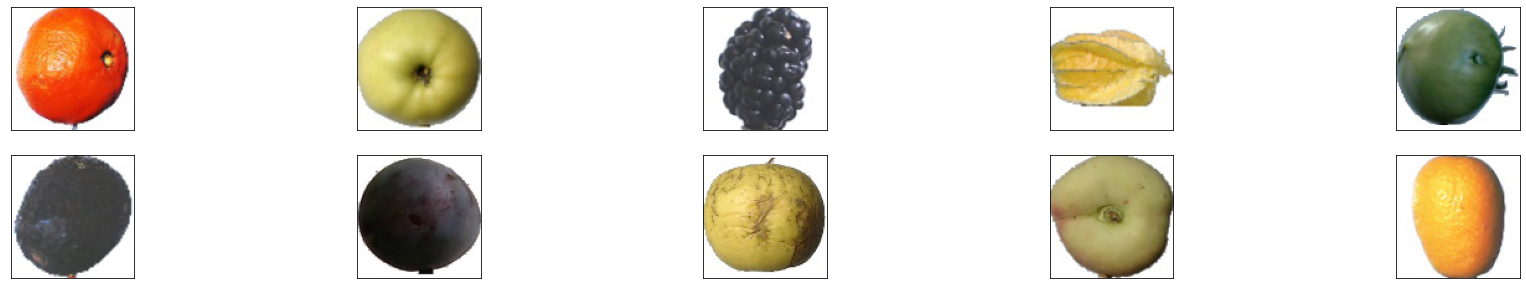

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize =(30,5))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(train_images_array[i]))
    print(names_train[i])

CNN architecture.

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, BatchNormalization
import os

model = Sequential()

model.add(Conv2D(64, (3, 3),input_shape= (100, 100, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))

model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))

model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))

model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))

model.add(MaxPool2D(pool_size=(3, 3)))

model.add(Flatten())

model.add(Dense(600)) #900
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(300)) #400
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(150)) #250
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(131,activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 98, 98, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 96, 96, 64)        0

In [21]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = "adam",
              metrics = ['accuracy'])
print('Compiled!')

Compiled!


In [22]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath = 'cnn_2.hdf5', verbose = 1, save_best_only = True)

history = model.fit(train_images_array, train_hot_class,
        batch_size = 32, #32
        epochs = 15, #15
        validation_data = (valid_images_array, valid_hot_class),
        callbacks = [checkpointer],
        verbose = 2, shuffle = True)

Epoch 1/15

Epoch 1: val_loss improved from inf to 0.18126, saving model to cnn_from_scratch_fruits.hdf5
1904/1904 - 3275s - loss: 1.8289 - accuracy: 0.5138 - val_loss: 0.1813 - val_accuracy: 0.9612 - 3275s/epoch - 2s/step
Epoch 2/15

Epoch 2: val_loss improved from 0.18126 to 0.13299, saving model to cnn_from_scratch_fruits.hdf5
1904/1904 - 3221s - loss: 0.4665 - accuracy: 0.8549 - val_loss: 0.1330 - val_accuracy: 0.9603 - 3221s/epoch - 2s/step
Epoch 3/15

Epoch 3: val_loss improved from 0.13299 to 0.01450, saving model to cnn_from_scratch_fruits.hdf5
1904/1904 - 3123s - loss: 0.2702 - accuracy: 0.9134 - val_loss: 0.0145 - val_accuracy: 0.9973 - 3123s/epoch - 2s/step
Epoch 4/15

Epoch 4: val_loss improved from 0.01450 to 0.01187, saving model to cnn_from_scratch_fruits.hdf5
1904/1904 - 3007s - loss: 0.1855 - accuracy: 0.9423 - val_loss: 0.0119 - val_accuracy: 0.9970 - 3007s/epoch - 2s/step
Epoch 5/15

Epoch 5: val_loss improved from 0.01187 to 0.00493, saving model to cnn_from_scratch

In [38]:
history

In [36]:
model.load_weights('cnn_from_scratch_fruits.hdf5')
score = model.evaluate(test_images_array, test_hot_class, verbose = 0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9872620105743408


In [26]:
model.save('/savedmodel/fullCNN')

INFO:tensorflow:Assets written to: /savedmodel/fullCNN\assets


INFO:tensorflow:Assets written to: /savedmodel/fullCNN\assets


In [32]:
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(train_images_array[10].reshape(1,100,100,1))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

ValueError: cannot reshape array of size 30000 into shape (1,100,100,1)

In [31]:
history.model.weights

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
 array([[[[ 0.37299627,  0.28487292, -0.08333396, ...,  0.01569402,
            0.0913573 ,  0.01387981],
          [-0.02537361,  0.20397668,  0.22736156, ...,  0.02110833,
            0.02766342,  0.2052238 ],
          [-0.10497751, -0.10687363, -0.08667335, ..., -0.11742964,
           -0.45573145,  0.10417784]],
 
         [[ 0.23080431,  0.37751174,  0.0469666 , ..., -0.00365343,
            0.04931111,  0.02165621],
          [-0.19601284,  0.28654987,  0.3674669 , ..., -0.16423628,
           -0.01847441,  0.1773358 ],
          [-0.08814535, -0.01489585, -0.12557173, ..., -0.30341703,
           -0.7064046 ,  0.01231417]],
 
         [[ 0.16740556,  0.25319418, -0.09004642, ...,  0.04022681,
           -0.03869787, -0.10673124],
          [-0.22700194,  0.07667401,  0.29645368, ..., -0.07236982,
            0.12526822,  0.06361652],
          [ 0.03054478, -0.1126614 ,  0.01235446, ..., -0.32407692,
    

In [33]:
import matplotlib.pyplot as plt
y_pred = model.predict(test_images_array)

fig = plt.figure(figsize=(32, 30))
for i, idx in enumerate(np.random.choice(test_images_array.shape[0], size = 32, replace = False)):
    ax = fig.add_subplot(8, 6, i + 1, xticks = [], yticks = [])
    ax.imshow(np.squeeze(test_images_array[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(test_hot_class[idx])
    ax.set_title("{} ({})".format(stringclass_test[pred_idx], stringclass_test[true_idx]),
                 color = ("green" if pred_idx == true_idx else "red"))

 87/709 [==>...........................] - ETA: 3:41

KeyboardInterrupt: 

Model accuracy

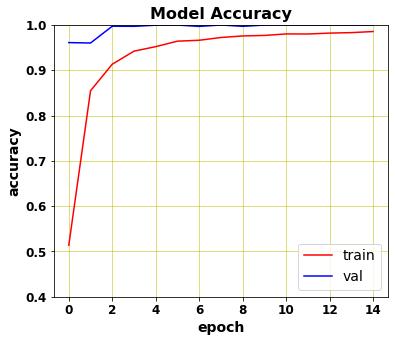

In [39]:
plt.figure(figsize = (6, 5))
plt.plot(history.history['accuracy'], color = 'r')
plt.plot(history.history['val_accuracy'], color = 'b')
plt.title('Model Accuracy', weight = 'bold', fontsize = 16)
plt.ylabel('accuracy', weight = 'bold', fontsize = 14)
plt.xlabel('epoch', weight = 'bold', fontsize = 14)
plt.ylim(0.4, 1)
plt.xticks(weight = 'bold', fontsize = 12)
plt.yticks(weight = 'bold', fontsize = 12)
plt.legend(['train', 'val'], loc = 'lower right', prop = {'size': 14})
plt.grid(color = 'y', linewidth = '0.5')
plt.show()

Show prediction.

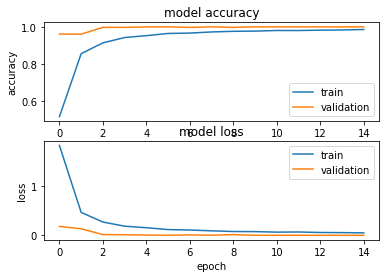

In [41]:
import matplotlib.pyplot as plt 
plt.figure(1)  
   
 # summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc = 'lower right')
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc = 'upper right')
plt.show()